<p style="font-size:36px;text-align:center"> <b>Personalized cancer diagnosis</b> </p>

##### Problem statement
- Classify the given genetic variations/mutations based on evidence from text-based clinical literature. 

- There are nine different classes a genetic mutation can be classified into => Multi class classification problem

In [9]:
# Importing all the reuired libraries

import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import seaborn as sns
import math
import re

from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, log_loss
from sklearn.linear_model import SGDClassifier
from scipy.sparse import hstack

from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from mlxtend.classifier import StackingClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

--------------------

#### DATA OVERVIEW ::

In [3]:
data = pd.read_csv('training_variants')
data.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [4]:
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


In [5]:
data_text =pd.read_csv("training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
data_text.head()

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [6]:
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


##### Preprocessing the text and then merging

In [10]:
stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
       
        total_text = re.sub('\s+',' ', total_text)
        
        total_text = total_text.lower()
        
        for word in total_text.split():
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

In [11]:
for index, row in data_text.iterrows():          
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755


In [13]:
result = pd.merge(data, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [14]:
result[result.isnull().any(axis=1)] 

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [15]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']  # Replacing NAN values with Gene+Variation

In [16]:
result[result['ID']==1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


In [28]:
result.duplicated().sum()

0

In [29]:
result.shape

(3321, 5)

In [30]:
result['Class'].value_counts()

7    953
4    686
1    568
2    452
6    275
5    242
3     89
9     37
8     19
Name: Class, dtype: int64

------

#### EDA ::

In [18]:
#Splitting data into train, test and cross validation

y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

x_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
train_df, cv_df, y_train, y_cv = train_test_split(x_train, y_train, stratify=y_train, test_size=0.2)

In [19]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


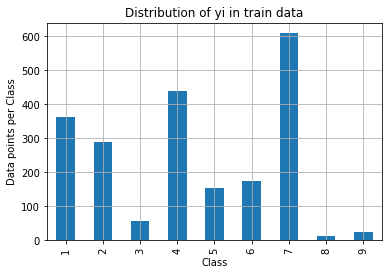

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)


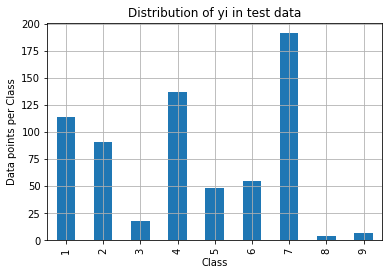

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)


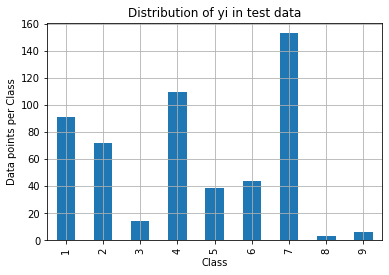

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


In [33]:
# Having a check of distribution of y_i's across Train, Test and Cross Validation 

train_class=train_df['Class'].value_counts().sort_index()
train_class.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()
sorted_y = np.argsort(-train_class.values)
for i in sorted_y:
    print('Number of data points in class', i+1, ':',train_class.values[i], '(', np.round((train_class.values[i]/train_df.shape[0]*100), 3), '%)')


test_class=test_df['Class'].value_counts().sort_index()
test_class.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()
sorted_y = np.argsort(-test_class.values)
for i in sorted_y:
    print('Number of data points in class', i+1, ':',test_class.values[i], '(', np.round((test_class.values[i]/test_df.shape[0]*100), 3), '%)')

    
cv_class=cv_df['Class'].value_counts().sort_index()
cv_class.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()
sorted_y = np.argsort(-cv_class.values)
for i in sorted_y:
    print('Number of data points in class', i+1, ':',cv_class.values[i], '(', np.round((cv_class.values[i]/cv_df.shape[0]*100), 3), '%)')

    


##### Findings :-
- Training, test and Cv is having the same distribution

##### UNIVARIATE ANALYSIS ::

###### Gene Feature:

In [34]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
# the top 10 genes that occured most
print(unique_genes.head(10))

Number of Unique Genes : 238
BRCA1     158
TP53      101
EGFR       87
PTEN       83
BRCA2      73
BRAF       57
KIT        56
ERBB2      48
ALK        44
PDGFRA     43
Name: Gene, dtype: int64


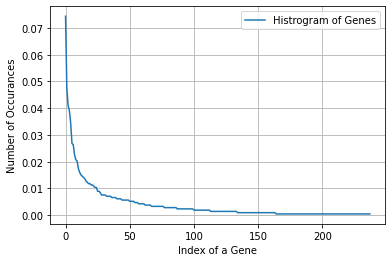

In [35]:
s = sum(unique_genes.values);
h = unique_genes.values/s;
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

- Skew distribution

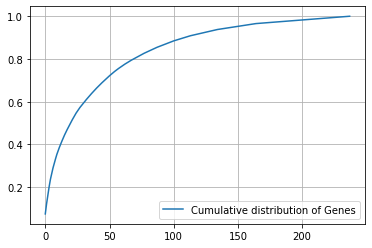

In [36]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

- Converting to vectors . Using Tfidf Vectorizer.


In [37]:
gene_vectorizer = TfidfVectorizer(max_features=1000)
train_gene_feature = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature = gene_vectorizer.transform(cv_df['Gene'])

In [39]:
gene_vectorizer.get_feature_names()[:10]

['abl1', 'ago2', 'akt1', 'akt2', 'akt3', 'alk', 'apc', 'ar', 'araf', 'arid1a']

###### variation Feature:

In [40]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])  #1932 unique among 2124 points....looks nearly same
# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1920
Truncating_Mutations    67
Amplification           48
Deletion                41
Fusions                 22
Overexpression           5
E17K                     3
G12V                     3
Y64A                     2
G13V                     2
TMPRSS2-ETV1_Fusion      2
Name: Variation, dtype: int64


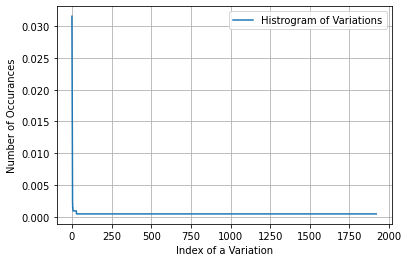

In [41]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

[0.03154426 0.05414313 0.07344633 ... 0.99905838 0.99952919 1.        ]


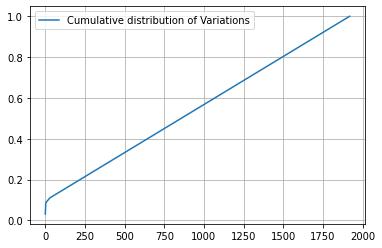

In [42]:
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

- There are many values that have occured very less times
- Converting this feature to vector

In [43]:
variation_vectorizer =TfidfVectorizer(max_features=1000)
train_variation_feature = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature = variation_vectorizer.transform(cv_df['Variation'])

In [44]:
variation_vectorizer.get_feature_names()[:10]

['126',
 'alk_fusion',
 'amplification',
 'bcr',
 'braf_fusion',
 'ccdc6_fusion',
 'deletion',
 'e17k',
 'e23fs',
 'e2419k']

######  Text Feature::

In [46]:
# building a tfidf with all the words that occured minimum 3 times in train data
text_vectorizer = TfidfVectorizer(min_df=3)
train_text_feature = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()
train_text_fea_counts = train_text_feature.sum(axis=0).A1
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))

print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 53220


In [47]:
# normalizing the features as preprocess has already completed

train_text_feature = normalize(train_text_feature, axis=0)

test_text_feature = text_vectorizer.transform(test_df['TEXT'])
test_text_feature = normalize(test_text_feature, axis=0)

cv_text_feature = text_vectorizer.transform(cv_df['TEXT'])
cv_text_feature = normalize(cv_text_feature, axis=0)

--------------------------

### MODEL BUILDING :-

- Using Logistic Regression, SVM, Random Forest
- Will evaluate the above models and pick the best one

In [49]:
# Joining the gene, variation, text columns

train_gene_var = hstack((train_gene_feature,train_variation_feature))
test_gene_var = hstack((test_gene_feature,test_variation_feature))
cv_gene_var = hstack((cv_gene_feature,cv_variation_feature))

train_x = hstack((train_gene_var, train_text_feature)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x = hstack((test_gene_var, test_text_feature)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x = hstack((cv_gene_var, cv_text_feature)).tocsr()
cv_y = np.array(list(cv_df['Class']))

In [51]:
print("Shape of train data = ", train_x.shape)
print("Shape of test data = ", test_x.shape)
print("Shape of cross validation data =", cv_x.shape)

Shape of train data =  (2124, 54458)
Shape of test data =  (665, 54458)
Shape of cross validation data = (532, 54458)


#### Logistic Regression:-

for alpha = 1e-06
Log Loss : 1.2854275591769266
for alpha = 1e-05
Log Loss : 1.1986291849785602
for alpha = 0.0001
Log Loss : 1.0432350645564052
for alpha = 0.001
Log Loss : 1.0392555795760292
for alpha = 0.01
Log Loss : 1.079089791702122
for alpha = 0.1
Log Loss : 1.2585237310121737
for alpha = 1
Log Loss : 1.536093092111948
for alpha = 10
Log Loss : 1.5808037260904169
for alpha = 100
Log Loss : 1.5857552388883196


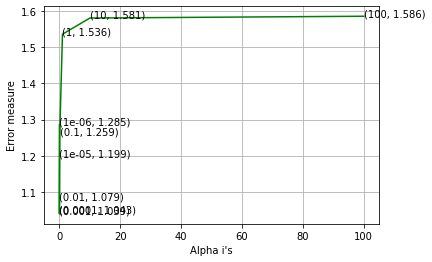

In [53]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    # using balanced weights to have equal importance
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)   
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs))
    

plt.plot(alpha, cv_log_error_array,c='g')
for i in range(len(alpha)):
    plt.annotate((alpha[i],np.round(cv_log_error_array[i],3)), (alpha[i],cv_log_error_array[i]))
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.grid()
plt.show()


In [55]:

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x, train_y)

predict_y = sig_clf.predict_proba(cv_x)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.001 The cross validation log loss is: 1.0392555795760292
For values of best alpha =  0.001 The test log loss is: 1.0975369164246394


Log loss : 1.0975369164246394


<AxesSubplot:>

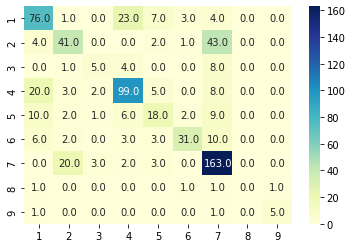

In [60]:
# applying the optimization

clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x, train_y)
pred_y = sig_clf.predict(test_x)

print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))

cm=confusion_matrix(test_y, pred_y)
sns.heatmap(cm,cmap="YlGnBu", annot=True, fmt='.1f', xticklabels=clf.classes_, yticklabels=clf.classes_)


- Having a check at the predictions

In [63]:
test_index = 1

predicted_cls = sig_clf.predict(test_x[test_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x[test_index]),4))
print("Actual Class :", test_y[test_index])

Predicted Class : 4
Predicted Class Probabilities: [[0.2846 0.0169 0.0067 0.6394 0.0186 0.0086 0.0184 0.0047 0.0019]]
Actual Class : 4


In [66]:
test_index = 111

predicted_cls = sig_clf.predict(test_x[test_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x[test_index]),4))
print("Actual Class :", test_y[test_index])

Predicted Class : 7
Predicted Class Probabilities: [[6.000e-04 4.545e-01 4.000e-04 5.000e-04 4.270e-02 5.000e-04 4.957e-01
  5.100e-03 0.000e+00]]
Actual Class : 7


#### Linear Support Vectors :-

for alpha = 1e-06
Log Loss : 1.262170744122691
for alpha = 1e-05
Log Loss : 1.2688560999682048
for alpha = 0.0001
Log Loss : 1.1986206424432326
for alpha = 0.001
Log Loss : 1.1259456116588151
for alpha = 0.01
Log Loss : 1.1303243417972564
for alpha = 0.1
Log Loss : 1.2877986033320503
for alpha = 1
Log Loss : 1.5865849404632753
for alpha = 10
Log Loss : 1.5866226575854685
for alpha = 100
Log Loss : 1.586622713177166


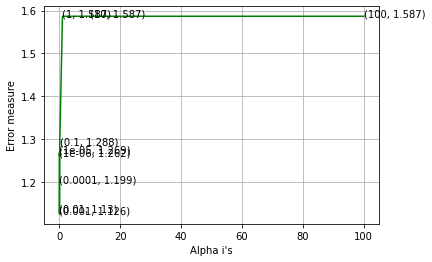

In [67]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    # using balanced weights to have equal importance
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)   
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs))
    

plt.plot(alpha, cv_log_error_array,c='g')
for i in range(len(alpha)):
    plt.annotate((alpha[i],np.round(cv_log_error_array[i],3)), (alpha[i],cv_log_error_array[i]))
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.grid()
plt.show()

In [68]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x, train_y)

predict_y = sig_clf.predict_proba(cv_x)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.001 The cross validation log loss is: 1.1259456116588151
For values of best alpha =  0.001 The test log loss is: 1.13883594284903


Log loss : 1.13883594284903


<AxesSubplot:>

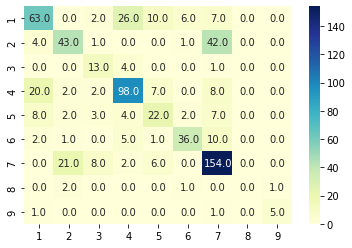

In [69]:
# applying the optimization

clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x, train_y)
pred_y = sig_clf.predict(test_x)

print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))

cm=confusion_matrix(test_y, pred_y)
sns.heatmap(cm,cmap="YlGnBu", annot=True, fmt='.1f', xticklabels=clf.classes_, yticklabels=clf.classes_)


- a bit increase in loss compared with LOGISTIC REGRESSION

- Having a check at the predictions

In [70]:
test_index = 1

predicted_cls = sig_clf.predict(test_x[test_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x[test_index]),4))
print("Actual Class :", test_y[test_index])

Predicted Class : 4
Predicted Class Probabilities: [[0.2073 0.0364 0.0112 0.6255 0.034  0.0126 0.0649 0.0046 0.0034]]
Actual Class : 4


In [71]:
test_index = 220

predicted_cls = sig_clf.predict(test_x[test_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x[test_index]),4))
print("Actual Class :", test_y[test_index])

Predicted Class : 3
Predicted Class Probabilities: [[0.0605 0.0289 0.3513 0.0535 0.1541 0.018  0.3193 0.0078 0.0065]]
Actual Class : 3


#### Random Forest :-

In [ ]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)   
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 
        

In [73]:
best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x, train_y)

predict_y = sig_clf.predict_proba(cv_x)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best estimator =  2000 The cross validation log loss is: 1.1068636078343137
For values of best estimator =  2000 The test log loss is: 1.140111738524609


Log loss : 1.1401117385246091


<AxesSubplot:>

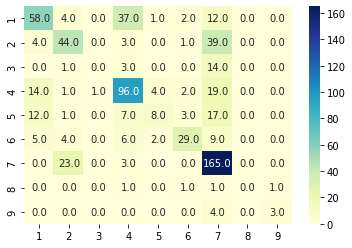

In [74]:
pred_y = sig_clf.predict(test_x)

print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))

cm=confusion_matrix(test_y, pred_y)
sns.heatmap(cm,cmap="YlGnBu", annot=True, fmt='.1f', xticklabels=clf.classes_, yticklabels=clf.classes_)

- Having a check at predictions

In [75]:
test_index = 1

predicted_cls = sig_clf.predict(test_x[test_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x[test_index]),4))
print("Actual Class :", test_y[test_index])

Predicted Class : 4
Predicted Class Probabilities: [[0.2235 0.0432 0.0192 0.5404 0.0497 0.038  0.0733 0.0057 0.007 ]]
Actual Class : 4


In [76]:
test_index = 59

predicted_cls = sig_clf.predict(test_x[test_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x[test_index]),4))
print("Actual Class :", test_y[test_index])

Predicted Class : 4
Predicted Class Probabilities: [[0.1377 0.027  0.0714 0.5839 0.0964 0.0498 0.0237 0.0051 0.0049]]
Actual Class : 4


### Conclusion:- 

- Logistic Regression (With class balanced) is having the less log loss. 
- Can have a increase at max_features in the vectorization and we can see changes at log loss.And can also apply n_grams.
- So, Logistic regression is the Preffered model.
